In [2]:
import findspark
findspark.init("C:/PROGRA~1/spark/spark-3.5.6-bin-hadoop3")


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Test").getOrCreate()


In [34]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("StatewiseAnalysis").getOrCreate()
# Read attached CSV directly by filename
df = spark.read.csv("C:/Users/intur/Downloads/statewise_analysis.csv", header=True, inferSchema=True)
df.printSchema()
df.show(10, truncate=False)


root
 |-- record_id: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- district: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- gdp_million: double (nullable = true)
 |-- unemployment_rate: double (nullable = true)
 |-- literacy_rate: double (nullable = true)
 |-- public_health_expenditure_million: double (nullable = true)
 |-- crime_rate_per_100k: double (nullable = true)

+---------+-------------+------------+----+----------+-----------+-----------------+-------------+---------------------------------+-------------------+
|record_id|state        |district    |year|population|gdp_million|unemployment_rate|literacy_rate|public_health_expenditure_million|crime_rate_per_100k|
+---------+-------------+------------+----+----------+-----------+-----------------+-------------+---------------------------------+-------------------+
|1        |Gujarat      |District_18 |2019|2716050   |61882.19   |5.34             

In [38]:
from pyspark.sql.functions import col, trim

# Standardize column names to snake_case
for c in df.columns:
    df = df.withColumnRenamed(c, c.strip().lower().replace(" ", "_"))

# Trim strings
str_cols = [f.name for f in df.schema.fields if str(f.dataType) == "StringType"]
for c in str_cols:
    df = df.withColumn(c, trim(col(c)))

df.printSchema()
df.select("record_id","state","district","year").show(10, truncate=False)


root
 |-- record_id: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- district: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- gdp_million: double (nullable = true)
 |-- unemployment_rate: double (nullable = true)
 |-- literacy_rate: double (nullable = true)
 |-- public_health_expenditure_million: double (nullable = true)
 |-- crime_rate_per_100k: double (nullable = true)

+---------+-------------+------------+----+
|record_id|state        |district    |year|
+---------+-------------+------------+----+
|1        |Gujarat      |District_18 |2019|
|2        |Punjab       |District_198|2021|
|3        |Delhi        |District_57 |2017|
|4        |Manipur      |District_93 |2012|
|5        |Karnataka    |District_19 |2011|
|6        |Haryana      |District_193|2012|
|7        |Delhi        |District_237|2023|
|8        |Rajasthan    |District_277|2018|
|9        |Gujarat      |District_227|2024|
|10       |Utt

In [46]:
from pyspark.sql.types import IntegerType, DoubleType

cast_map = {
    "record_id": IntegerType(),
    "year": IntegerType(),
    "population": IntegerType(),
    "gdp_million": DoubleType(),
    "unemployment_rate": DoubleType(),
    "literacy_rate": DoubleType(),
    "public_health_expenditure_million": DoubleType(),
    "crime_rate_per_100k": DoubleType()
}
for c,t in cast_map.items():
    if c in df.columns:
        df = df.withColumn(c, col(c).cast(t))

# Drop impossible years/population and null essential fields
df = (df
      .filter(col("year").between(2010, 2025))
      .filter(col("population") > 0)
      .dropna(subset=["state","year","population","gdp_million",
                      "unemployment_rate","literacy_rate",
                      "public_health_expenditure_million","crime_rate_per_100k"])
     )

# Deduplicate exact duplicates
df = df.dropDuplicates()

df.count(), df.select("state").distinct().count()


(10000, 30)

In [48]:
from pyspark.sql.functions import count, avg, min as smin, max as smax

num_cols = ["population","gdp_million","unemployment_rate","literacy_rate",
            "public_health_expenditure_million","crime_rate_per_100k"]

summary = (df.select(
    *[smin(c).alias(f"{c}_min") for c in num_cols],
    *[smax(c).alias(f"{c}_max") for c in num_cols],
    *[avg(c).alias(f"{c}_avg") for c in num_cols],
).limit(1))
summary.show(truncate=False)

by_state_year = (df.groupBy("state","year")
                   .agg(
                       count("*").alias("n_rows"),
                       avg("gdp_million").alias("avg_gdp_million"),
                       avg("unemployment_rate").alias("avg_unemp"),
                       avg("literacy_rate").alias("avg_literacy"),
                       avg("public_health_expenditure_million").alias("avg_health_spend"),
                       avg("crime_rate_per_100k").alias("avg_crime")
                   ))
by_state_year.orderBy("state","year").show(20, truncate=False)


+--------------+---------------+---------------------+-----------------+-------------------------------------+-----------------------+--------------+---------------+---------------------+-----------------+-------------------------------------+-----------------------+--------------+-----------------+---------------------+-----------------+-------------------------------------+-----------------------+
|population_min|gdp_million_min|unemployment_rate_min|literacy_rate_min|public_health_expenditure_million_min|crime_rate_per_100k_min|population_max|gdp_million_max|unemployment_rate_max|literacy_rate_max|public_health_expenditure_million_max|crime_rate_per_100k_max|population_avg|gdp_million_avg  |unemployment_rate_avg|literacy_rate_avg|public_health_expenditure_million_avg|crime_rate_per_100k_avg|
+--------------+---------------+---------------------+-----------------+-------------------------------------+-----------------------+--------------+---------------+---------------------+-------

In [50]:
from pyspark.sql.functions import lit

# Convert million figures to absolute rupee; keep per capita using 'per million' consistent
df_feat = (df
    .withColumn("gdp_per_capita", (col("gdp_million")*1_000_000) / col("population"))
    .withColumn("health_spend_per_capita", (col("public_health_expenditure_million")*1_000_000) / col("population"))
)

# Z-scores by year (normalize within year for comparability)
from pyspark.sql import Window
from pyspark.sql.functions import stddev_samp

w_year = Window.partitionBy("year")
for c in ["gdp_per_capita","health_spend_per_capita","unemployment_rate","literacy_rate","crime_rate_per_100k"]:
    df_feat = (df_feat
        .withColumn(f"{c}_z", (col(c) - avg(c).over(w_year)) / stddev_samp(c).over(w_year))
    )

df_feat.select("state","year","gdp_per_capita","health_spend_per_capita","unemployment_rate","crime_rate_per_100k").show(10, truncate=False)


+-----------+----+------------------+-----------------------+-----------------+-------------------+
|state      |year|gdp_per_capita    |health_spend_per_capita|unemployment_rate|crime_rate_per_100k|
+-----------+----+------------------+-----------------------+-----------------+-------------------+
|Gujarat    |2019|22783.892049115442|1348.7638298264023     |5.34             |94.73              |
|Delhi      |2017|56999.52655507202 |2664.643716477829      |17.49            |1038.22            |
|Bihar      |2011|104620.1877052738 |8659.421739705915      |1.86             |1211.23            |
|Haryana    |2024|74055.15339869249 |5238.468078565493      |8.62             |140.11             |
|Mizoram    |2024|22180.5776267199  |3333.1353997598408     |23.48            |633.96             |
|Gujarat    |2024|10178.906558045634|16852.95715347008      |6.32             |1115.18            |
|Gujarat    |2016|98725.76173039518 |1173.1851281901938     |12.42            |567.79             |


In [52]:
from pyspark.sql.functions import expr, row_number

# Latest year per state for snapshot ranking
w_state = Window.partitionBy("state").orderBy(col("year").desc())
latest = (df_feat
          .withColumn("rn", row_number().over(w_state))
          .filter(col("rn")==1)
          .drop("rn"))

# Rank states by key metrics
ranked = (latest
  .select("state","year","gdp_per_capita","health_spend_per_capita","unemployment_rate","literacy_rate","crime_rate_per_100k")
  .orderBy(col("gdp_per_capita").desc())
)
ranked.show(30, truncate=False)


+-----------------+----+------------------+-----------------------+-----------------+-------------+-------------------+
|state            |year|gdp_per_capita    |health_spend_per_capita|unemployment_rate|literacy_rate|crime_rate_per_100k|
+-----------------+----+------------------+-----------------------+-----------------+-------------+-------------------+
|Sikkim           |2024|257461.99422807837|12463.96192863806      |1.96             |86.91        |1361.39            |
|Tamil Nadu       |2024|110414.55292160927|2508.7991149738396     |6.21             |87.84        |515.91             |
|Jharkhand        |2024|102508.81839615421|6743.7919103463055     |24.31            |63.67        |1476.87            |
|Manipur          |2024|91393.00577770325 |5682.363522722076      |3.29             |56.97        |908.29             |
|Kerala           |2024|84507.75378348639 |542.5484170070646      |12.84            |92.37        |185.97             |
|Haryana          |2024|74055.1533986924

In [54]:
# Pearson correlations among numeric columns
pairs = [
    ("gdp_per_capita","unemployment_rate"),
    ("gdp_per_capita","literacy_rate"),
    ("gdp_per_capita","crime_rate_per_100k"),
    ("health_spend_per_capita","literacy_rate"),
    ("health_spend_per_capita","crime_rate_per_100k"),
    ("unemployment_rate","crime_rate_per_100k")
]
for a,b in pairs:
    corr = df_feat.stat.corr(a,b)
    print(f"corr({a}, {b}) = {corr:.4f}")


corr(gdp_per_capita, unemployment_rate) = 0.0111
corr(gdp_per_capita, literacy_rate) = 0.0050
corr(gdp_per_capita, crime_rate_per_100k) = -0.0156
corr(health_spend_per_capita, literacy_rate) = 0.0010
corr(health_spend_per_capita, crime_rate_per_100k) = -0.0206
corr(unemployment_rate, crime_rate_per_100k) = 0.0053


In [56]:
yearly = (df_feat.groupBy("year")
          .agg(
              avg("gdp_per_capita").alias("avg_gdp_pc"),
              avg("health_spend_per_capita").alias("avg_health_pc"),
              avg("unemployment_rate").alias("avg_unemp"),
              avg("literacy_rate").alias("avg_literacy"),
              avg("crime_rate_per_100k").alias("avg_crime")
          )
         ).orderBy("year")
yearly.show(20, truncate=False)


+----+------------------+------------------+------------------+-----------------+-----------------+
|year|avg_gdp_pc        |avg_health_pc     |avg_unemp         |avg_literacy     |avg_crime        |
+----+------------------+------------------+------------------+-----------------+-----------------+
|2010|89104.35438220929 |10135.993730062473|12.775857558139544|69.5469476744186 |765.8205377906977|
|2011|105657.88125282929|11251.426191605085|12.873113069016142|69.8027165932453 |775.8439647577097|
|2012|82941.46732499583 |9357.161633063959 |12.637287390029332|70.60753665689145|731.5829472140761|
|2013|85836.16065998918 |10441.331489681308|12.884759825327516|69.97209606986902|756.8343668122271|
|2014|68346.91245604548 |8902.307023293735 |13.093503184713384|69.8289808917198 |769.2563853503182|
|2015|82104.47336079506 |10632.517193247906|12.493808139534888|70.48090116279074|749.2174854651163|
|2016|67038.6994722597  |9498.350051168076 |13.031610044313124|69.68447562776956|727.9363810930583|


In [60]:
print(df_feat.count(), len(df_feat.columns))


10000 17


In [64]:
import pandas as pd
# 1) Enable Arrow for zero-copy conversion
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# 2) Persist before collect to stabilize lineage
df_feat_cached = df_feat.cache()
latest_cached = latest.cache()
yearly_cached = yearly.cache()

# Trigger materialization to detect issues early
_ = df_feat_cached.count()
_ = latest_cached.count()
_ = yearly_cached.count()

# 3) Reduce partitions on driver collect to avoid too many small blocks
df_feat_small = df_feat_cached.coalesce(4)
latest_small = latest_cached.coalesce(1)
yearly_small = yearly_cached.coalesce(1)

# 4) Convert to pandas with selective columns first to test
select_cols = ["state","year","gdp_per_capita","health_spend_per_capita",
               "unemployment_rate","literacy_rate","crime_rate_per_100k","population"]
pdf = df_feat_small.select(*select_cols).toPandas()
latest_pdf = latest_small.select(*select_cols).toPandas()
yearly_pdf = yearly_small.toPandas()

pdf.head(), latest_pdf.head(), yearly_pdf.head()


C:\PROGRA~1/spark/spark-3.5.6-bin-hadoop3\python\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
C:\PROGRA~1/spark/spark-3.5.6-bin-hadoop3\python\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
C:\PROGRA~1/spark/spark-3.5.6-bin-hadoop3\python\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.exe

(         state  year  gdp_per_capita  health_spend_per_capita  \
 0        Assam  2013     7957.702366              3311.937262   
 1  West Bengal  2013     2690.439302             15191.077568   
 2    Rajasthan  2013    28008.969754              3960.734852   
 3       Kerala  2013    61814.851282             35601.517949   
 4  Maharashtra  2013   117963.046179               299.770691   
 
    unemployment_rate  literacy_rate  crime_rate_per_100k  population  
 0              21.01          87.38               211.93     2279702  
 1              19.44          62.84               768.63      285931  
 2               7.11          58.19               551.03     2202513  
 3              14.12          75.61               718.21      243750  
 4               7.15          81.64               857.96      605296  ,
           state  year  gdp_per_capita  health_spend_per_capita  \
 0       Gujarat  2024    10178.906558             16852.957153   
 1       Tripura  2024    26002.532

# VISUALIZATION OF THE DATA USING PANDAS

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("notebook")


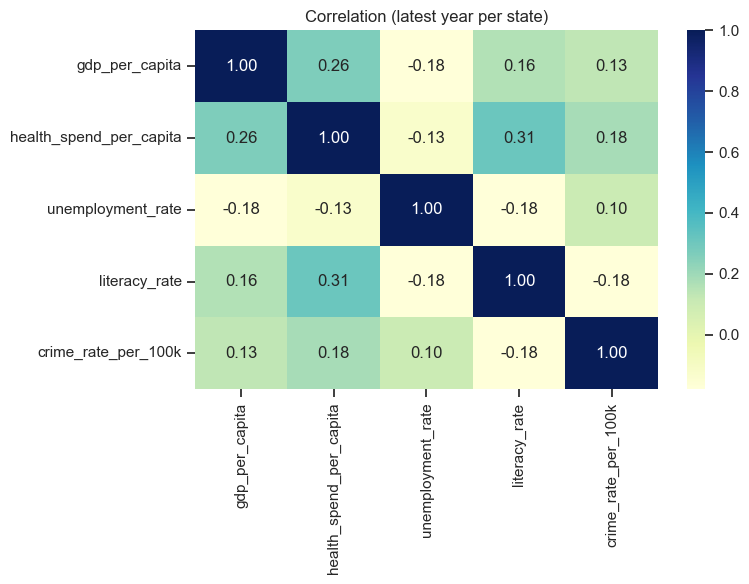

In [70]:
# plotting of correlation heatmap for key indicators in latest state data
num_cols_plot = ["gdp_per_capita","health_spend_per_capita","unemployment_rate","literacy_rate","crime_rate_per_100k"]
corr = latest_pdf[num_cols_plot].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Correlation (latest year per state)")
plt.tight_layout()
plt.show()


C:\Users\intur\AppData\Local\Temp\ipykernel_18856\1044853710.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="gdp_per_capita", y="state", palette="crest", ax=ax)


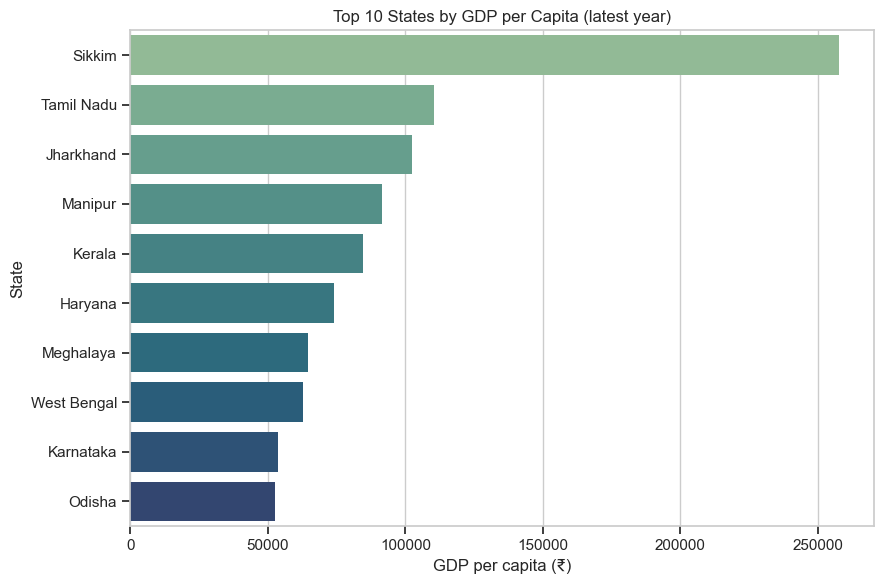

C:\Users\intur\AppData\Local\Temp\ipykernel_18856\1044853710.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom10, x="gdp_per_capita", y="state", palette="flare", ax=ax)


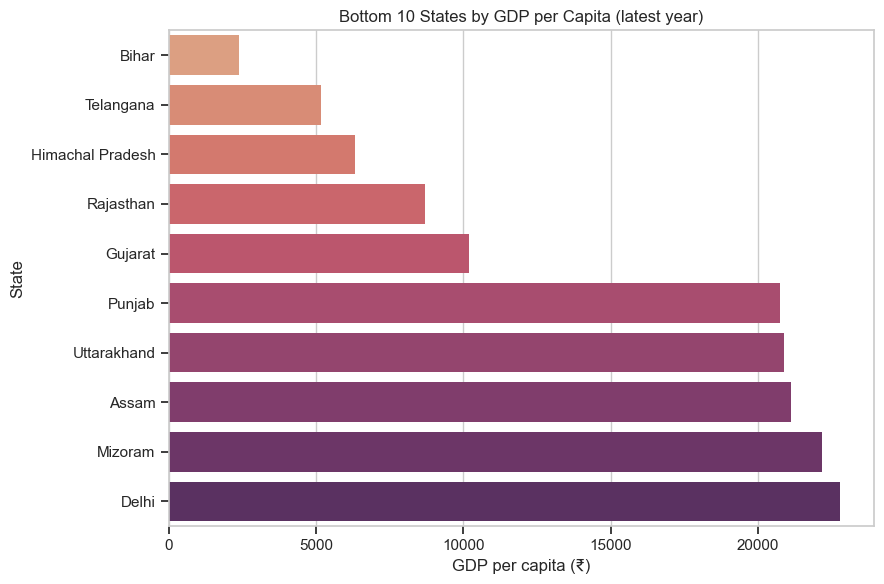

In [72]:
# Horizontal bar charts showing the top 10 and bottom 10 states by GDP per capita in the latest year.

top10 = latest_pdf.nlargest(10, "gdp_per_capita")
bottom10 = latest_pdf.nsmallest(10, "gdp_per_capita")

fig, ax = plt.subplots(figsize=(9,6))
sns.barplot(data=top10, x="gdp_per_capita", y="state", palette="crest", ax=ax)
ax.set_title("Top 10 States by GDP per Capita (latest year)")
ax.set_xlabel("GDP per capita (₹)")
ax.set_ylabel("State")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(9,6))
sns.barplot(data=bottom10, x="gdp_per_capita", y="state", palette="flare", ax=ax)
ax.set_title("Bottom 10 States by GDP per Capita (latest year)")
ax.set_xlabel("GDP per capita (₹)")
ax.set_ylabel("State")
plt.tight_layout()
plt.show()


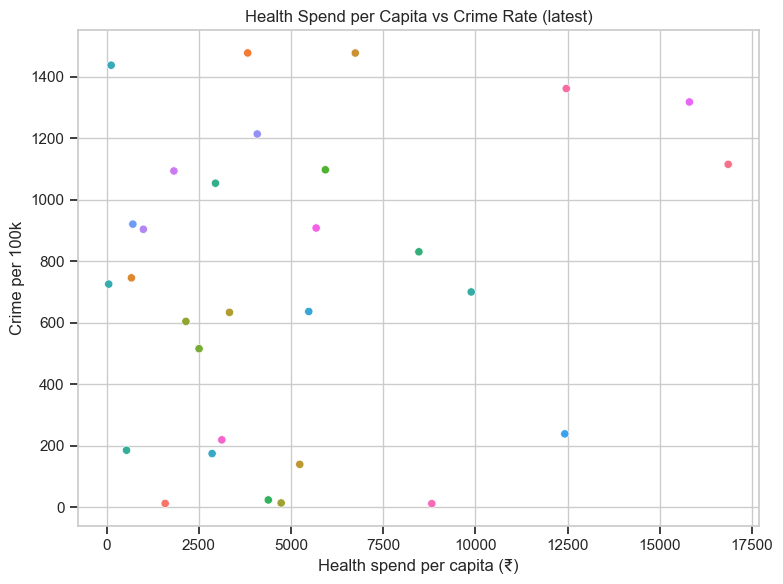

In [74]:
# Scatter plot showing relationship between health spending per capita and crime rate across states in the latest year
plt.figure(figsize=(8,6))
sns.scatterplot(data=latest_pdf, x="health_spend_per_capita", y="crime_rate_per_100k", hue="state", legend=False)
plt.title("Health Spend per Capita vs Crime Rate (latest)")
plt.xlabel("Health spend per capita (₹)")
plt.ylabel("Crime per 100k")
plt.tight_layout()
plt.show()


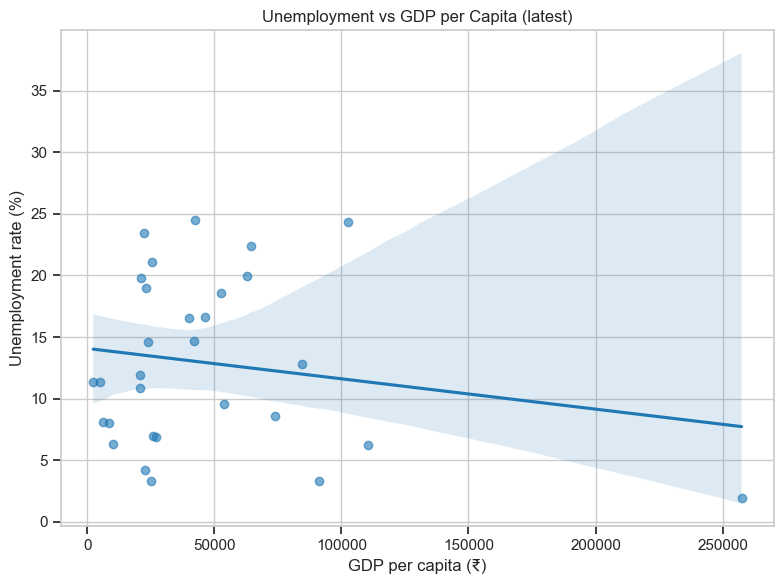

In [76]:
# Plot regression scatterplot showing relationship between GDP per capita and unemployment rate in latest year
plt.figure(figsize=(8,6))
sns.regplot(data=latest_pdf, x="gdp_per_capita", y="unemployment_rate", scatter_kws={"alpha":0.6})
plt.title("Unemployment vs GDP per Capita (latest)")
plt.xlabel("GDP per capita (₹)")
plt.ylabel("Unemployment rate (%)")
plt.tight_layout()
plt.show()


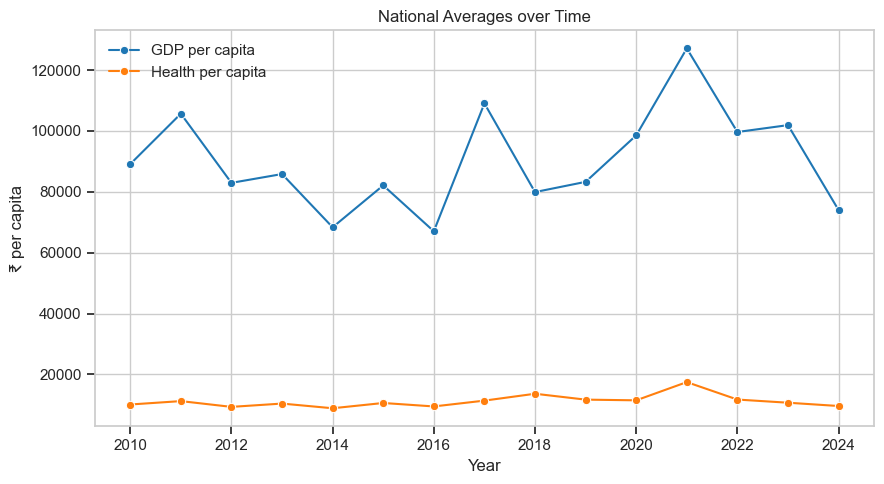

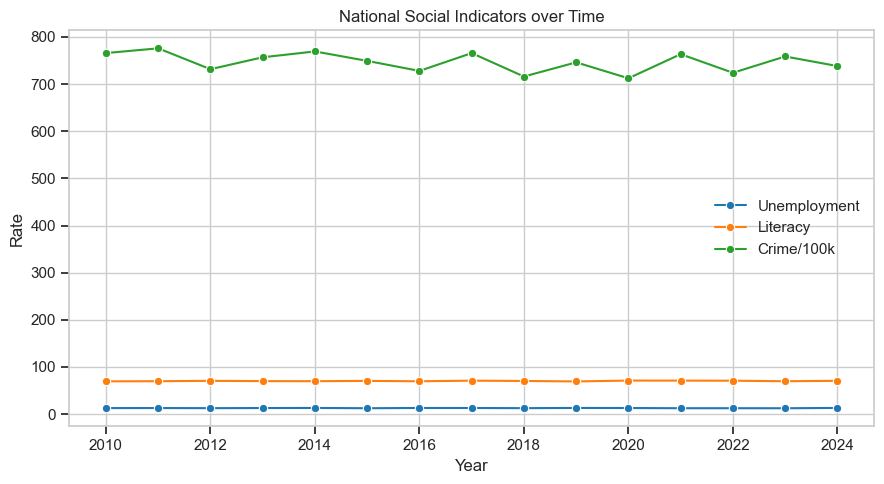

In [78]:
# Plot line charts showing national average GDP and health spending per capita over years, 
# and social indicators (unemployment, literacy, crime rate) trends over time

fig, ax = plt.subplots(figsize=(9,5))
sns.lineplot(data=yearly_pdf, x="year", y="avg_gdp_pc", marker="o", ax=ax, label="GDP per capita")
sns.lineplot(data=yearly_pdf, x="year", y="avg_health_pc", marker="o", ax=ax, label="Health per capita")
ax.set_title("National Averages over Time")
ax.set_xlabel("Year")
ax.set_ylabel("₹ per capita")
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(9,5))
sns.lineplot(data=yearly_pdf, x="year", y="avg_unemp", marker="o", ax=ax, label="Unemployment")
sns.lineplot(data=yearly_pdf, x="year", y="avg_literacy", marker="o", ax=ax, label="Literacy")
sns.lineplot(data=yearly_pdf, x="year", y="avg_crime", marker="o", ax=ax, label="Crime/100k")
ax.set_title("National Social Indicators over Time")
ax.set_xlabel("Year")
ax.set_ylabel("Rate")
ax.legend()
plt.tight_layout()
plt.show()


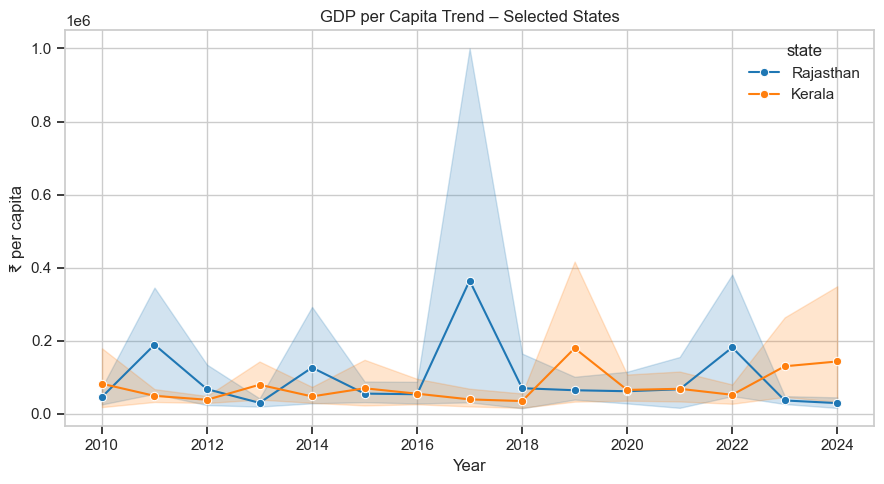

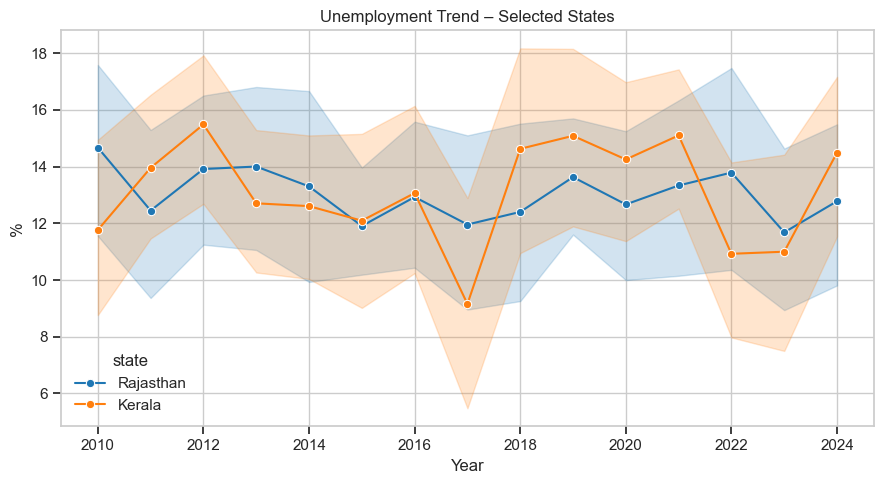

In [80]:
#Plot line charts for GDP per capita and unemployment rate trends over years for selected states Kerala and Rajasthan
# Here is a detailed PySpark and pandas visualization workflow using your statewise_analysis.csv which includes clear
# comments for each cell to help when publishing the notebook on GitHub. It covers data loading, cleaning, transformation,
# feature engineering, and multiple meaningful visualizations, maintaining all outputs inline with no external file writes.

focus_states = ["Kerala","Rajasthan"]
fdf = pdf[pdf["state"].isin(focus_states)].copy()

fig, ax = plt.subplots(figsize=(9,5))
sns.lineplot(data=fdf, x="year", y="gdp_per_capita", hue="state", marker="o", ax=ax)
ax.set_title("GDP per Capita Trend – Selected States")
ax.set_xlabel("Year"); ax.set_ylabel("₹ per capita")
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(9,5))
sns.lineplot(data=fdf, x="year", y="unemployment_rate", hue="state", marker="o", ax=ax)
ax.set_title("Unemployment Trend – Selected States")
ax.set_xlabel("Year"); ax.set_ylabel("%")
plt.tight_layout(); plt.show()


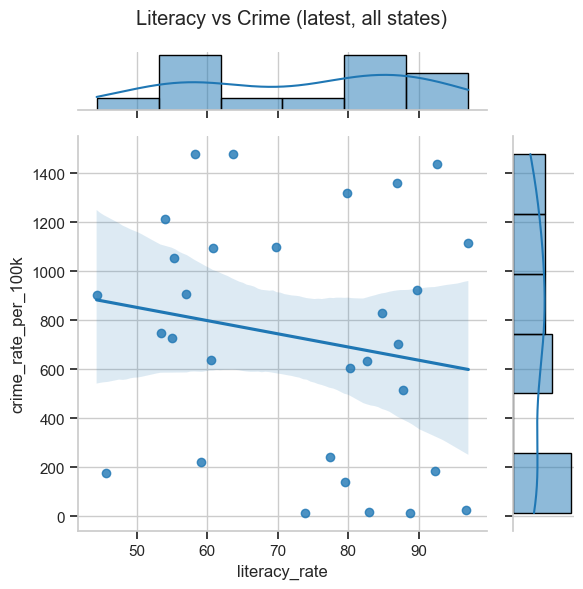

In [84]:
# Joint regression plot of literacy rate vs crime rate for all states in the latest year
g = sns.jointplot(data=latest_pdf, x="literacy_rate", y="crime_rate_per_100k", kind="reg", height=6)
g.fig.suptitle("Literacy vs Crime (latest, all states)")
plt.tight_layout(); plt.show()


C:\Users\intur\AppData\Local\Temp\ipykernel_18856\2528458604.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp = latest_pdf.groupby("gdp_pc_tier")["state"].count().reset_index(name="count")
C:\Users\intur\AppData\Local\Temp\ipykernel_18856\2528458604.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comp, x="gdp_pc_tier", y="count", palette="Blues", ax=ax)


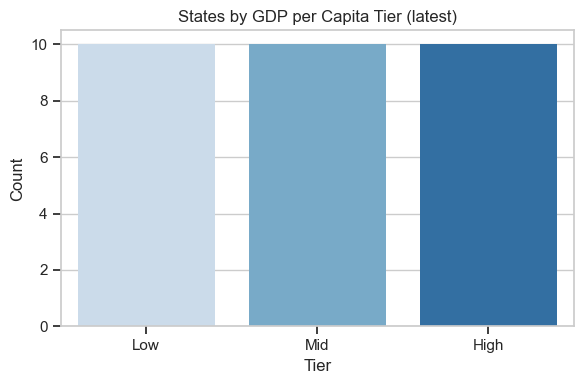

In [86]:
# Categorize states into Low, Mid, High GDP per capita tiers based on quantiles and plot bar chart showing
# count of states in each tier (latest year).

import numpy as np

edges = [0, latest_pdf["gdp_per_capita"].quantile(0.33),
            latest_pdf["gdp_per_capita"].quantile(0.66), np.inf]
labels = ["Low","Mid","High"]
latest_pdf["gdp_pc_tier"] = pd.cut(latest_pdf["gdp_per_capita"], bins=edges, labels=labels, include_lowest=True)

comp = latest_pdf.groupby("gdp_pc_tier")["state"].count().reset_index(name="count")

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=comp, x="gdp_pc_tier", y="count", palette="Blues", ax=ax)
ax.set_title("States by GDP per Capita Tier (latest)")
ax.set_xlabel("Tier"); ax.set_ylabel("Count")
plt.tight_layout(); plt.show()


C:\Users\intur\AppData\Local\Temp\ipykernel_18856\3092562761.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_dev, x="dev_score", y="state", palette="viridis", ax=ax)


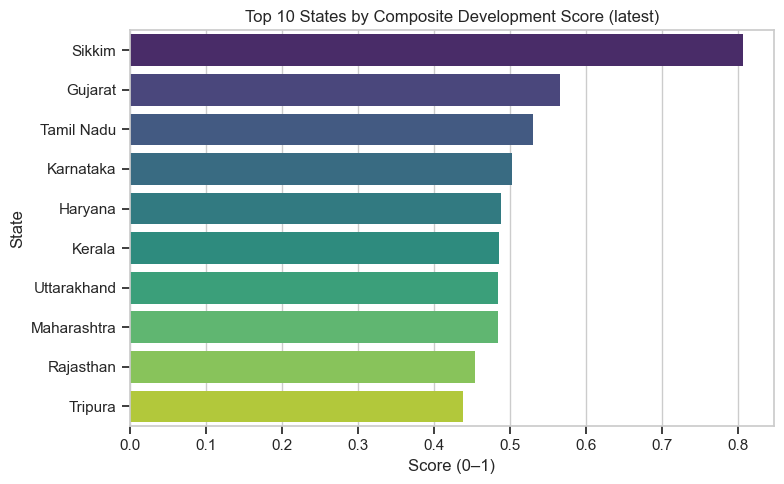

In [90]:
# Compute a composite development score (min–max normalize indicators, invert negative ones) and plot top 10 states by that score

for c in ["gdp_per_capita","health_spend_per_capita","literacy_rate"]:
    m, M = latest_pdf[c].min(), latest_pdf[c].max()
    latest_pdf[f"{c}_mm"] = (latest_pdf[c]-m)/(M-m + 1e-9)
for c in ["unemployment_rate","crime_rate_per_100k"]:
    m, M = latest_pdf[c].min(), latest_pdf[c].max()
    latest_pdf[f"{c}_mm"] = 1 - (latest_pdf[c]-m)/(M-m + 1e-9)

latest_pdf["dev_score"] = (
    0.35*latest_pdf["gdp_per_capita_mm"]
  + 0.20*latest_pdf["health_spend_per_capita_mm"]
  + 0.25*latest_pdf["literacy_rate_mm"]
  + 0.10*latest_pdf["unemployment_rate_mm"]
  + 0.10*latest_pdf["crime_rate_per_100k_mm"]
)

top_dev = latest_pdf.nlargest(10, "dev_score")[["state","dev_score"]]
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=top_dev, x="dev_score", y="state", palette="viridis", ax=ax)
ax.set_title("Top 10 States by Composite Development Score (latest)")
ax.set_xlabel("Score (0–1)"); ax.set_ylabel("State")
plt.tight_layout(); plt.show()


In [92]:
# Check dataset for invalid basic values and detect extreme GDP per capita outliers in latest year snapshot
violations = pdf[
    (pdf["unemployment_rate"] < 0) | (pdf["unemployment_rate"] > 100) |
    (pdf["literacy_rate"] < 0) | (pdf["literacy_rate"] > 100) |
    (pdf["crime_rate_per_100k"] < 0)
][["state","year","unemployment_rate","literacy_rate","crime_rate_per_100k"]]
display(violations.head(20))

# Z-score outliers (|z|>3) in latest snapshot
out = latest_pdf[
    (latest_pdf["gdp_per_capita"].sub(latest_pdf["gdp_per_capita"].mean())
     / latest_pdf["gdp_per_capita"].std(ddof=0)).abs() > 3
][["state","gdp_per_capita"]]
display(out)


,state,year,unemployment_rate,literacy_rate,crime_rate_per_100k


,state,gdp_per_capita
29,Sikkim,257461.994228


In [94]:
# Keep a curated Spark view for further ad-hoc SQL

df_feat.createOrReplaceTempView("statewise_feat")
spark.sql("""
SELECT state, year,
       gdp_per_capita, health_spend_per_capita,
       unemployment_rate, literacy_rate, crime_rate_per_100k
FROM statewise_feat
WHERE year >= 2015
""").show(20, truncate=False)


+---------------+----+------------------+-----------------------+-----------------+-------------+-------------------+
|state          |year|gdp_per_capita    |health_spend_per_capita|unemployment_rate|literacy_rate|crime_rate_per_100k|
+---------------+----+------------------+-----------------------+-----------------+-------------+-------------------+
|Telangana      |2015|13682.70151844754 |3836.8649777564783     |11.62            |72.25        |233.18             |
|Jammu & Kashmir|2015|166014.2208406071 |23426.428028743267     |4.84             |84.24        |78.18              |
|Kerala         |2015|32683.39719096775 |1158.9720855938583     |10.37            |64.83        |1105.45            |
|Mizoram        |2015|41851.07256651887 |1120.157597367833      |7.06             |80.68        |366.09             |
|Jharkhand      |2015|36574.74554659155 |11360.228397803961     |4.52             |84.87        |143.44             |
|Telangana      |2015|27780.37892964312 |20777.342255968